In [ ]:
import sys, os
sys.path.append('..')
sys.path.append('../..')

In [ ]:
import autograd

In [ ]:
import pickle

In [ ]:
import pystan

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       make_stan_log_density,
                       adagrad_optimize
                      )
from experiments import (get_samples_and_log_weights, 
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

In [ ]:
from paragami import PSDSymmetricMatrixPattern
#_unvectorize_ld_matrix

In [7]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

In [8]:
from viabel.functions import compute_posterior_moments

In [9]:
print(PSDSymmetricMatrixPattern.fold)

<function PSDSymmetricMatrixPattern.fold at 0x11f98ea60>


# Linear regression model example

We will approximate the posterior for the simple 2D robust linear regression model
$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{1000000}(\beta^\top x_n, 1).$$

We will use Stan to take care of compute log probabilities and gradients for us. 

In [10]:
regression_model_code = """data {
  int<lower=0> N;   // number of observations
  int<lower=0> D;   // number of observations
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[D] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  #y ~ student_t(10000000, x * beta, 1);  // likelihood
  y ~ normal( x * beta, 0.5);  // likelihood
}"""

In [11]:

try:
    sm = pickle.load(open('robust_reg_model_1.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_1.pkl', 'wb') as f:
        pickle.dump(sm, f)


We generate 25 observations from the model with $\beta = (-2, 1)$.

In [12]:
SEED=5040
np.random.seed(SEED)
beta_gen = np.array([-2, 1])
N = 100
k=10
x = np.random.randn(N, 2).dot(np.array([[1,.85],[.85, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(10, N)
y = y_raw - np.mean(y_raw)

In [13]:
N=200
k=20
SEED= 5080
alpha=1.
noise_sigma = 0.4
noise_var = noise_sigma**2
rho = 0.5
regression_data = data_generator_linear(N, k, alpha=alpha,
                                                     noise_variance=noise_var,
                                                     rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

First, we generate ground truth samples using Stan's dynamic HMC implementation

In [14]:
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [15]:
posterior_mean_hmc = np.mean(fit['beta'], axis=0)
posterior_cov_hmc = np.cov(fit['beta'].T)

In [16]:
posterior_std_hmc = np.sqrt(np.diag(posterior_cov_hmc))

In [17]:
print(posterior_mean_hmc)

[ 0.00917655 -0.37958553 -1.32279526  1.05778705 -1.45606972  2.14761095
 -0.4412331  -0.09487607  0.00791715 -0.5595145   1.76968822  0.45970445
 -0.11632106  0.0496653   0.73397418 -0.15220493 -0.48332081  0.20328598
  1.36095144  1.36527602]


#### Here, we compute the posterior moments analytically.

In [18]:
prior_mean = np.zeros((k, 1))
prior_covariance = np.eye(k)
true_mean, true_cov = compute_posterior_moments(prior_mean,
                                                            prior_covariance,
                                                            noise_var, X, Y[:,None])

true_mean = true_mean.flatten()

true_std = np.sqrt(np.diag(true_cov))

#### Difference Between True posterior mean and HMC mean estimate.
The difference is quite small even after summing over all dimensions.

In [19]:
#print(posterior_mean)
print('Difference between analytical mean and HMC mean:', np.sum(np.square(posterior_mean_hmc - true_mean)))
print('Difference between analytical covariance and HMC covariance:', np.sum(np.square(posterior_cov_hmc - true_cov)))
print('Difference between analytical std dev and HMC std dev:', np.sum(np.square(posterior_std_hmc - true_std)))
print('Difference between analytical z-score and HMC z-score:', np.sqrt(np.mean(np.square((posterior_mean_hmc - true_mean)/true_std))))

Difference between analytical mean and HMC mean: 0.00013152176791031707
Difference between analytical covariance and HMC covariance: 1.7897839551892018e-05
Difference between analytical std dev and HMC std dev: 0.001720761272741545
Difference between analytical z-score and HMC z-score: 0.06741361957657035


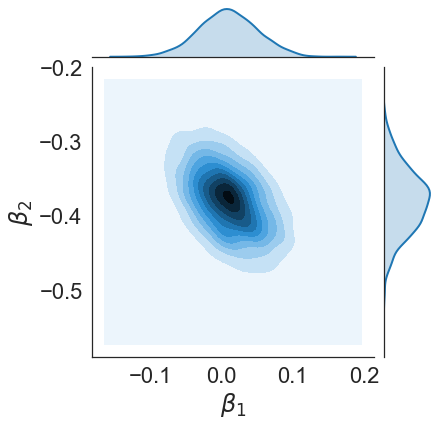

In [20]:
jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
plt.show()

## Standard mean-field variational inference

Next, we compute a mean field variational approximation using standard variational inference (that is, minimizing the KL-divergence)

#### Here we will investigate if Iterate Averaging(IA) really improves estimation of variational parameters 
#### first with mean field approximation and then full rank approximation on ELBO objective values.
#### We also show the effect of using path gradients, which always give a slightly better estimate of ELBO:

In [21]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)

In [22]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
stan_log_density = make_stan_log_density(fit)
klvi_mf_objective_and_grad = black_box_klvi(mf_g_var_family, stan_log_density, 100)
klvi_fr_objective_and_grad = black_box_klvi(fr_g_var_family, stan_log_density, 100)
init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000



In [23]:
klvi_mf_objective_and_grad_pd = black_box_klvi_pd2(mf_g_var_family, stan_log_density, 100)
klvi_fr_objective_and_grad_pd = black_box_klvi_pd2(fr_g_var_family, stan_log_density, 100)
init_mean    = np.zeros(k)
#init_mean_random = np.random.normal([k], stddev=1.0)
init_log_std = np.ones(k)
#init_log_std_random = tf.random.normal([k], stddev=1.)
init_var_param = np.concatenate([init_mean, init_log_std])
init_fr_var_param = np.concatenate([init_mean, np.ones(int(k*(k+1)/2))])

####  First we use mean field Gaussian as proposal density

In [24]:
klvi_var_param_rms, klvi_var_param_list_rms, avg_klvi_mean_list_rms, avg_klvi_sigmas_list_rms, klvi_history_rms, _, op_log_mf_rms = \
    rmsprop_IA_optimize_with_rhat(7000, klvi_mf_objective_and_grad, init_var_param, k, learning_rate=.01,n_optimisers=2, avg_grad_norm=False)

Average Loss = 92.6203: 100%|██████████| 7000/7000 [01:26<00:00, 80.75it/s] 


In [25]:
print('Difference between analytical mean and VI-RMSProp-IA mean:', np.sum(np.square(avg_klvi_mean_list_rms[0][-1] - true_mean)))
print('Difference between analytical mean and VI-RMSProp mean:', np.sum(np.square(klvi_var_param_list_rms[0][-1,:k] - true_mean)))
print('Difference between analytical std dev and VI-RMSProp-IA std dev:', np.sum(np.square(np.exp(avg_klvi_sigmas_list_rms[0][-1]) - true_std)))
print('Difference between analytical std dev and VI-RMSProp std dev:', np.sum(np.square(np.exp(klvi_var_param_list_rms[0][-1,k:]) - true_std)))
print('Difference between analytical z-score and VI-RMSProp-IA z-score:', np.sqrt(np.mean(np.square((avg_klvi_mean_list_rms[0][-1] - true_mean)/true_std))))
print('Difference between analytical z-score and VI-RMSProp z-score:', np.sqrt(np.mean(np.square((klvi_var_param_list_rms[0][-1,:k] - true_mean)/true_std))))

Difference between analytical mean and VI-RMSProp-IA mean: 0.00010664078292986295
Difference between analytical mean and VI-RMSProp mean: 0.001375063545326274
Difference between analytical std dev and VI-RMSProp-IA std dev: 0.0002117360655698209
Difference between analytical std dev and VI-RMSProp std dev: 0.00021513107710510507
Difference between analytical z-score and VI-RMSProp-IA z-score: 0.06037672196671377
Difference between analytical z-score and VI-RMSProp z-score: 0.224902894994664


###### Iterations taken to converge to stationary process Brownian motion according to r-hat for mean parameter and sigma parameter respectively.

In [26]:
print(op_log_mf_rms['start_avg_mean_iters'])
print(op_log_mf_rms['start_avg_sigma_iters'])

R_hat_mean_window = op_log_mf_rms['r_hat_mean']
R_hat_sigma_window = op_log_mf_rms['r_hat_sigma']
R_hat_mean_halfway = op_log_mf_rms['r_hat_mean_halfway']
R_hat_sigma_halfway = op_log_mf_rms['r_hat_sigma_halfway']

500
1000


##### Plot for R-hat (fixed window) and R-hat halfway
The Rhat halfway is computed at an interval of 100 iterations using the last 50% iterations, while Rhat window uses fixed windows of 500 iterations .., we here plot the Rhats averaged over all the dimensions.

(0.8, 2.5)

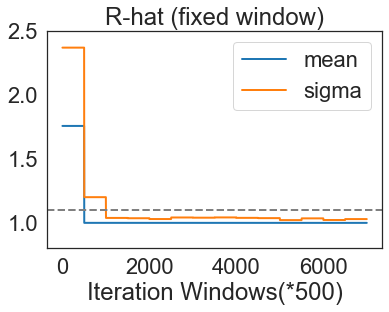

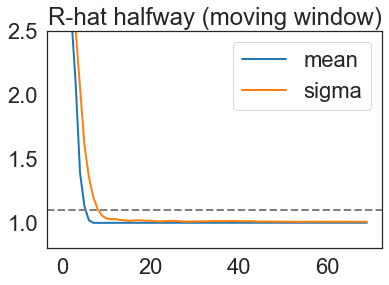

In [52]:
plt.plot(np.repeat(np.mean(R_hat_mean_window, axis=1), 500), label='mean')
plt.plot(np.repeat(np.mean(R_hat_sigma_window, axis=1), 500), label='sigma')
plt.ylim((0.8,2.5))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('R-hat (fixed window)')
plt.legend()
plt.xlabel('Iteration Windows(*500)')

plt.figure()
plt.plot(np.mean(R_hat_mean_halfway, axis=1), label='mean')
plt.plot(np.mean(R_hat_sigma_halfway, axis=1), label='sigma')
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.legend()
plt.title('R-hat halfway (moving window)')
plt.ylim((0.8,2.5))

####  Distance from true mean values for the optimisers

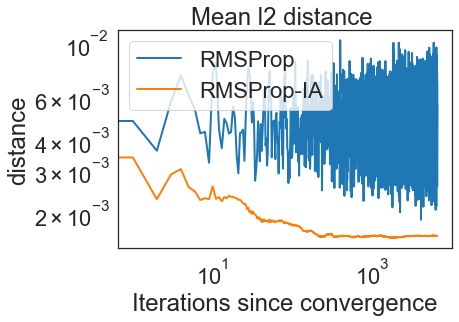

In [28]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_rms[0][op_log_mf_rms['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_mean_list_rms[0] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('Mean l2 distance ')
plt.legend()

##### Rhat plot for mean parameter computed for fixed window size of 500.

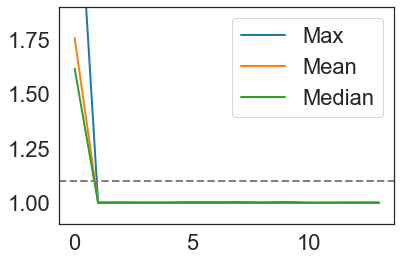

In [29]:
plt.plot(np.max(R_hat_mean_window,axis=1), label='Max')
plt.plot(np.mean(R_hat_mean_window,axis=1), label='Mean')
plt.plot(np.median(R_hat_mean_window,axis=1), label='Median')
plt.ylim((0.9,1.9))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.legend()

##### Rhat plot for sigma parameter computed for fixed window size of 500.

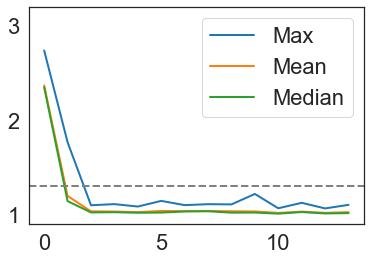

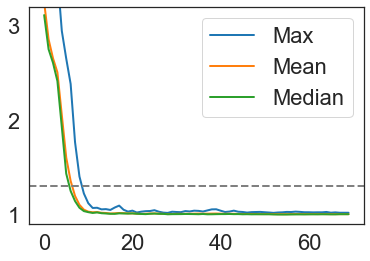

In [30]:
plt.plot(np.max(R_hat_sigma_window,axis=1), label='Max')
plt.plot(np.mean(R_hat_sigma_window,axis=1), label='Mean')
plt.plot(np.median(R_hat_sigma_window,axis=1), label='Median')
plt.ylim((0.9,3.2))
plt.axhline(y=1.30, linestyle='--', color="gray")
plt.legend()
plt.figure()
plt.plot(np.max(R_hat_sigma_halfway,axis=1), label='Max')
plt.plot(np.mean(R_hat_sigma_halfway,axis=1), label='Mean')
plt.plot(np.median(R_hat_sigma_halfway,axis=1), label='Median')
plt.ylim((0.9,3.2))
plt.axhline(y=1.30, linestyle='--', color="gray")
plt.legend()

####  Distance from true std dev. values for the optimisers

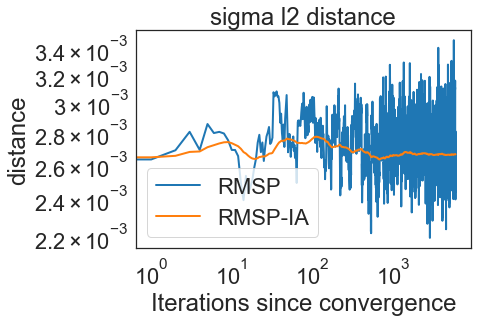

In [31]:
plt.loglog(np.mean(np.sqrt(np.square(np.exp(klvi_var_param_list_rms[0][op_log_mf_rms['start_avg_sigma_iters']:,k:]) - true_std)), axis=1), label='RMSP')
plt.loglog(np.mean(np.sqrt(np.square(np.exp(avg_klvi_sigmas_list_rms[0]) - true_std)), axis=1), label='RMSP-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('sigma l2 distance')
plt.legend()

####  Distance from true z-score values for the optimisers

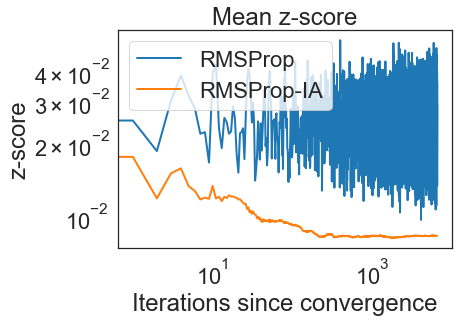

In [32]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_rms[0][op_log_mf_rms['start_avg_mean_iters']:,:k] - true_mean)/true_std), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_mean_list_rms[0] - true_mean)/true_std), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score')
plt.legend()

##### Same as above but with path gradients

In [33]:
klvi_var_param_rms_pd, klvi_var_param_list_rms_pd,  avg_klvi_mean_list_rms_pd, avg_klvi_sigmas_list_rms_pd, klvi_history_rms_pd, _, op_log_mf_rms_pd = \
    rmsprop_IA_optimize_with_rhat(7000, klvi_mf_objective_and_grad_pd, init_var_param, k, learning_rate=.01,n_optimisers=1)

Average Loss = 92.6303: 100%|██████████| 7000/7000 [01:46<00:00, 65.73it/s] 


###### Iterations taken to converge to stationary distribution Brownian motion according to r-hat

In [34]:
print('Iterations:', op_log_mf_rms_pd['start_avg_mean_iters'])
print('Iterations:', op_log_mf_rms_pd['start_avg_sigma_iters'])

Iterations: 500
Iterations: 500


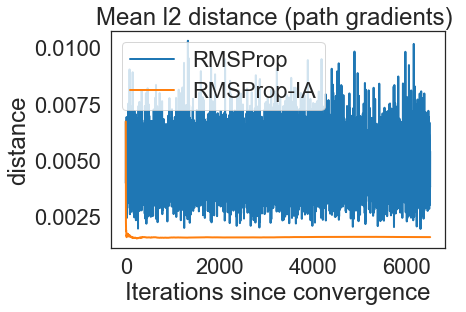

In [35]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_pd[0][op_log_mf_rms_pd['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='RMSProp')
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_mean_list_rms_pd[0] - true_mean.T)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('Mean l2 distance (path gradients) ')
plt.legend()

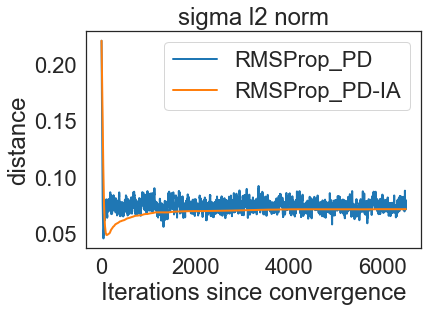

In [36]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_pd[0][op_log_mf_rms_pd['start_avg_sigma_iters']:,k:] - np.log(true_std))), axis=1), label='RMSProp_PD')
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_sigmas_list_rms_pd[0] - np.log(true_std))), axis=1), label='RMSProp_PD-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('sigma l2 norm')
plt.legend()

### Now we use Full rank Gaussian as proposal density.

In [37]:
klvi_fr_var_param_rms, klvi_fr_var_param_list_rms, avg_klvi_fr_mean_list_rms, avg_klvi_fr_sigmas_list_rms, fr_klvi_history_rms, _, op_log_fr_rms = \
    rmsprop_IA_optimize_with_rhat(13000, klvi_fr_objective_and_grad, init_fr_var_param, k, learning_rate=.01,n_optimisers=2, r_mean_threshold=1.15)

Average Loss = 122.747: 100%|██████████| 13000/13000 [04:04<00:00, 53.07it/s]


In [38]:
fr_g_var_family

VariationalFamily(sample=<function t_variational_family.<locals>.sample at 0x1243cbd08>, entropy=<function t_variational_family.<locals>.entropy at 0x1243cbd90>, logdensity=<paragami.function_patterns.FlattenFunctionInput object at 0x11f9f1320>, mean_and_cov=<function t_variational_family.<locals>.mean_and_cov at 0x1243cbe18>, pth_moment=<function t_variational_family.<locals>.pth_moment at 0x1243cbea0>, var_param_dim=230)

##### Iterations taken for convergence with RMSProp using R-hat fixed window statistic

In [39]:
print('Iterations for mean parameters:',op_log_fr_rms['start_avg_mean_iters'])
print('Iterations for sigma parameters:',op_log_fr_rms['start_avg_sigma_iters'])

Iterations for mean parameters: 500
Iterations for sigma parameters: 1500


In [40]:
R_hat_mean_window_fr = op_log_fr_rms['r_hat_mean']
R_hat_sigma_window_fr = op_log_fr_rms['r_hat_sigma']
R_hat_mean_halfway_fr = op_log_fr_rms['r_hat_mean_halfway']
R_hat_sigma_halfway_fr = op_log_fr_rms['r_hat_sigma_halfway']

In [41]:
cov_iters_fr_rms = [fr_g_var_family.mean_and_cov(a)[1] for a in klvi_fr_var_param_list_rms[0]]
mean_iters_fr_rms = [fr_g_var_family.mean_and_cov(a)[0] for a in klvi_fr_var_param_list_rms[0]]


In [42]:
cov_iters_fr_rms_flat = [fr_g_var_family.mean_and_cov(a)[1].flatten() for a in klvi_fr_var_param_list_rms[0]]
cov_iters_fr_rms_std = [np.sqrt(np.diag(fr_g_var_family.mean_and_cov(a)[1])) for a in klvi_fr_var_param_list_rms[0]]

In [43]:
cov_iters_fr_rms_ia = [fr_g_var_family.mean_and_cov(np.hstack((np.zeros(k), a)))[1] for a in avg_klvi_fr_sigmas_list_rms[0]]
cov_iters_fr_rms_ia_flat = [fr_g_var_family.mean_and_cov(np.hstack((np.zeros(k), a)))[1].flatten() for a in avg_klvi_fr_sigmas_list_rms[0]]
cov_iters_fr_rms_ia_std = [np.sqrt(np.diag(fr_g_var_family.mean_and_cov(np.hstack((np.zeros(k), a)))[1])) for a in avg_klvi_fr_sigmas_list_rms[0]]

In [44]:
print(true_cov.shape)
print(cov_iters_fr_rms_ia[0].shape)

(20, 20)
(20, 20)


In [45]:
print('Difference between analytical mean and VI-RMSProp-IA mean:', np.sum(np.square(avg_klvi_fr_mean_list_rms[0][-1] - true_mean)))
print('Difference between analytical mean and VI-RMSProp mean:', np.sum(np.square(klvi_var_param_list_rms[0][-1,:k] - true_mean)))
print('Difference between analytical cov and VI-RMSProp-IA cov:', np.sum(np.square(cov_iters_fr_rms_ia[-1] -true_cov)))
print('Difference between analytical cov and VI-RMSProp cov:', np.sum(np.square(cov_iters_fr_rms[-1] - true_cov)))
print('Difference between analytical std dev and VI-RMSProp-IA std dev:', np.sum(np.square(cov_iters_fr_rms_ia_std[-1] -true_std)))
print('Difference between analytical std dev and VI-RMSProp std dev:', np.sum(np.square(cov_iters_fr_rms_std[-1] - true_std)))

print('Difference between analytical z-score and VI-RMSProp-IA z-score:', np.sqrt(np.mean(np.square((avg_klvi_fr_mean_list_rms[0][-1] - true_mean)/true_std))))
print('Difference between analytical z-score and VI-RMSProp z-score:', np.sqrt(np.mean(np.square((klvi_var_param_list_rms[0][-1,:k] - true_mean)/true_std))))

Difference between analytical mean and VI-RMSProp-IA mean: 0.00010376024259451526
Difference between analytical mean and VI-RMSProp mean: 0.001375063545326274
Difference between analytical cov and VI-RMSProp-IA cov: 1.811203599498974e-05
Difference between analytical cov and VI-RMSProp cov: 4.933650573999382e-05
Difference between analytical std dev and VI-RMSProp-IA std dev: 0.0017869073429107043
Difference between analytical std dev and VI-RMSProp std dev: 0.0030862197759719133
Difference between analytical z-score and VI-RMSProp-IA z-score: 0.05955401988534076
Difference between analytical z-score and VI-RMSProp z-score: 0.224902894994664


##### Plot for R-hat (fixed window) and R-hat halfway for full rank approximation .
The Rhat halfway is computed at interval of 100 iterations using the last 50% iterations, while Rhat window uses fixed windows of 500 iterations .., we here plot the Rhats averaged over all the dimensions.

(0.8, 2.1)

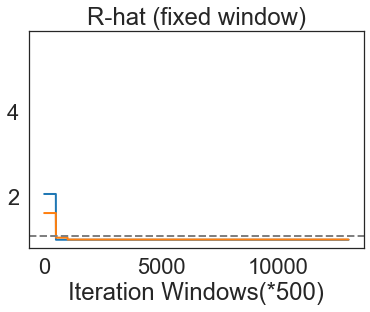

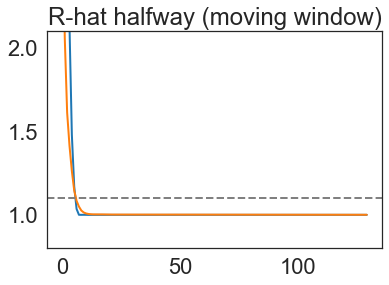

In [46]:
plt.plot(np.repeat(np.mean(R_hat_mean_window_fr, axis=1), 500), label='mean')
plt.plot(np.repeat(np.mean(R_hat_sigma_window_fr, axis=1), 500), label='sigma')
plt.ylim((0.8,5.9))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('R-hat (fixed window)')
plt.xlabel('Iteration Windows(*500)')

plt.figure()
plt.plot(np.mean(R_hat_mean_halfway_fr, axis=1))
plt.plot(np.mean(R_hat_sigma_halfway_fr, axis=1))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('R-hat halfway (moving window)')
plt.ylim((0.8,2.1))

#### The staircase behaviour is because the r hat is computed only after 500 iterations ... 

#### Plot for evolution of difference between mean-parameter  and true mean after convergence detected by R-hat

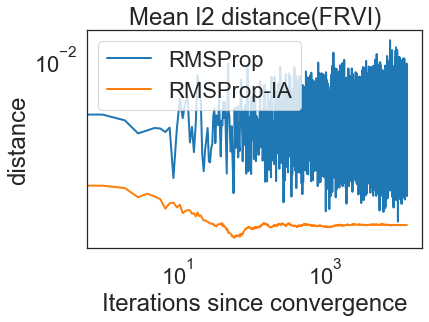

In [47]:
plt.loglog(np.mean(np.sqrt(np.square(mean_iters_fr_rms[op_log_fr_rms['start_avg_mean_iters']:] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_fr_mean_list_rms[0] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('Mean l2 distance(FRVI)')
plt.legend()

#### Plot for evolution of difference between approximate covariance matrix and true covariance matrix.

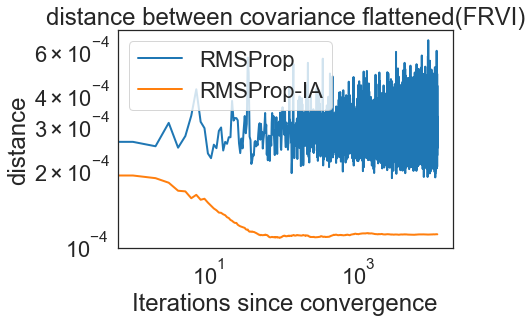

In [48]:
plt.loglog(np.mean(np.sqrt(np.square(cov_iters_fr_rms_flat[op_log_fr_rms['start_avg_sigma_iters']:] - true_cov.flatten())), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(cov_iters_fr_rms_ia_flat - true_cov.flatten())), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('distance between covariance flattened(FRVI)')
plt.legend()

#### Plot for evolution of difference between approximate marginal std dev.  and true marginals

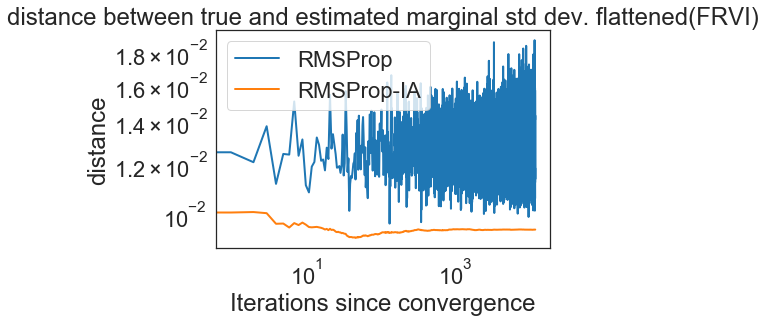

In [49]:
plt.loglog(np.mean(np.sqrt(np.square(cov_iters_fr_rms_std[op_log_fr_rms['start_avg_sigma_iters']:] - true_std)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(cov_iters_fr_rms_ia_std - true_std)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('distance between true and estimated marginal std dev. flattened(FRVI)')
plt.legend()

#### Plot for evolution of difference between approximate z-score.  and true z-score

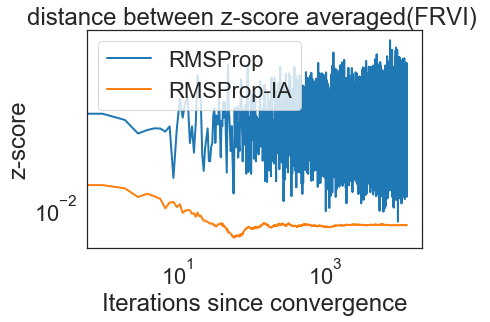

In [50]:
plt.loglog(np.mean(np.sqrt(np.square(mean_iters_fr_rms[op_log_fr_rms['start_avg_mean_iters']:] - true_mean)/true_std), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_fr_mean_list_rms[0] - true_mean)/true_std), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('distance between z-score averaged(FRVI) ')
plt.legend()

In [51]:
#plt.loglog(np.mean(np.sqrt(np.square(np.exp(klvi_fr_var_param_list_rms[0][op_log_fr_rms['start_avg_sigma_iters']:,k:]) - true_std)), axis=1), label='RMSP')
#plt.loglog(np.mean(np.sqrt(np.square(np.exp(avg_klvi_fr_var_param_list_rms[0][:,k:]) - true_std)), axis=1), label='RMSP-IA')
#plt.xlabel('Iterations since convergence')
#plt.ylabel('z-score')
#plt.title('Mean z-score')
#plt.legend()

### ADAM Optimiser
#### Same expts as above but with ADAM optimiser

In [54]:
klvi_var_param_adam, klvi_var_param_list_adam, avg_klvi_mean_list_adam, avg_klvi_sigmas_list_adam, klvi_history_adam, _, op_log_mf_adam = \
    adam_IA_optimize_with_rhat(13000, klvi_mf_objective_and_grad, init_var_param, k, learning_rate=.01,n_optimisers=2, r_mean_threshold=1.10)

Average Loss = 92.1418: 100%|██████████| 13000/13000 [02:42<00:00, 79.86it/s]


###### Iterations taken to converge to stationary distribution Brownian motion according to r-hat

In [55]:
print(op_log_mf_adam['start_avg_mean_iters'])
print(op_log_mf_adam['start_avg_sigma_iters'])

R_hat_mean_window_adam = op_log_mf_adam['r_hat_mean']
R_hat_sigma_window_adam = op_log_mf_adam['r_hat_sigma']
R_hat_mean_halfway_adam = op_log_mf_adam['r_hat_mean_halfway']
R_hat_sigma_halfway_adam = op_log_mf_adam['r_hat_sigma_halfway']

4500
11000


##### Plot for R-hat (fixed window) and R-hat halfway for ADAM optimiser
The Rhat halfway is computed at interval of 100 iterations using the last 50% iterations, while Rhat window uses fixed windows of 500 iterations .., we here plot the Rhats averaged over all the dimensions.

(0.8, 3.5)

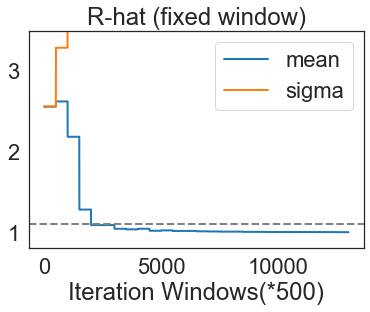

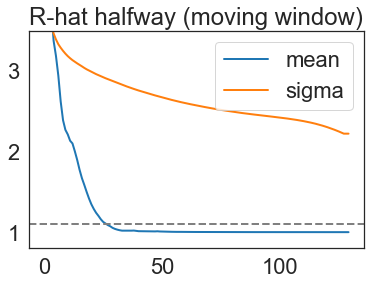

In [63]:
plt.plot(np.repeat(np.mean(R_hat_mean_window_adam, axis=1), 500), label='mean')
plt.plot(np.repeat(np.mean(R_hat_sigma_window_adam, axis=1), 500), label='sigma')
plt.ylim((0.8,3.5))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('R-hat (fixed window)')
plt.legend()
plt.xlabel('Iteration Windows(*500)')

plt.figure()
plt.plot(np.mean(R_hat_mean_halfway_adam, axis=1), label='mean')
plt.plot(np.mean(R_hat_sigma_halfway_adam, axis=1), label='sigma')
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.legend()
plt.title('R-hat halfway (moving window)')
plt.ylim((0.8,3.5))

####  Distance from true mean values for the optimisers

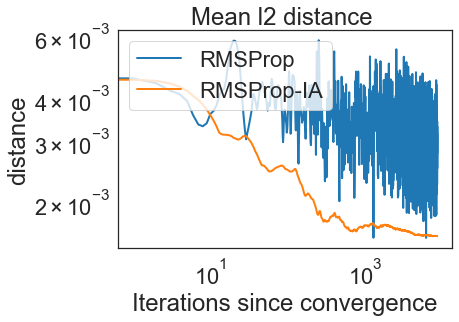

In [57]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_adam[0][op_log_mf_adam['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_mean_list_adam[0] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('Mean l2 distance ')
plt.legend()

####  Distance from true sigma values for the optimisers

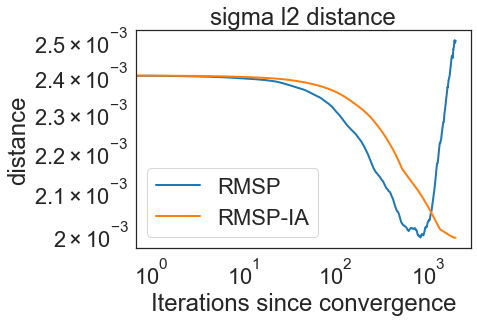

In [59]:
plt.loglog(np.mean(np.sqrt(np.square(np.exp(klvi_var_param_list_adam[0][op_log_mf_adam['start_avg_sigma_iters']:,k:]) - true_std)), axis=1), label='RMSP')
plt.loglog(np.mean(np.sqrt(np.square(np.exp(avg_klvi_sigmas_list_adam[0]) - true_std)), axis=1), label='RMSP-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('sigma l2 distance')
plt.legend()

####  Distance from true z-score values for the optimisers

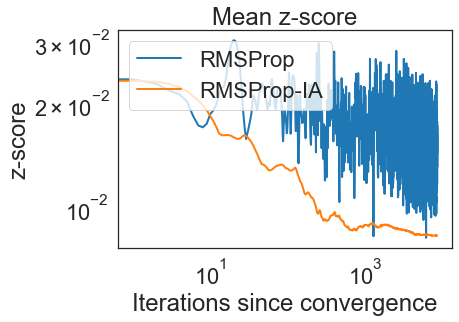

In [61]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_adam[0][op_log_mf_adam['start_avg_mean_iters']:,:k] - true_mean)/true_std), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_mean_list_adam[0] - true_mean)/true_std), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score')
plt.legend()

## Full rank ADVI with ADAM.

In [70]:
klvi_fr_var_param_adam, klvi_fr_var_param_list_adam,  avg_klvi_fr_mean_list_adam, avg_klvi_fr_sigmas_list_adam, fr_klvi_history_adam, _, op_log_fr_adam = \
    adam_IA_optimize_with_rhat(15000, klvi_fr_objective_and_grad, init_fr_var_param, k, learning_rate=.01,n_optimisers=2, r_mean_threshold=1.15)

Average Loss = 118.344: 100%|██████████| 15000/15000 [04:59<00:00, 50.11it/s]


In [72]:
R_hat_mean_window_fr_adam = op_log_fr_adam['r_hat_mean']
R_hat_sigma_window_fr_adam = op_log_fr_adam['r_hat_sigma']
R_hat_mean_halfway_fr_adam = op_log_fr_adam['r_hat_mean_halfway']
R_hat_sigma_halfway_fr_adam = op_log_fr_adam['r_hat_sigma_halfway']

In [73]:
cov_iters_fr_adam = [fr_g_var_family.mean_and_cov(a)[1] for a in klvi_fr_var_param_list_adam[0]]
mean_iters_fr_adam = [fr_g_var_family.mean_and_cov(a)[0] for a in klvi_fr_var_param_list_adam[0]]

In [74]:
cov_iters_fr_adam_flat = [fr_g_var_family.mean_and_cov(a)[1].flatten() for a in klvi_fr_var_param_list_adam[0]]
cov_iters_fr_adam_std = [np.sqrt(np.diag(fr_g_var_family.mean_and_cov(a)[1])) for a in klvi_fr_var_param_list_adam[0]]

In [75]:
cov_iters_fr_adam_ia = [fr_g_var_family.mean_and_cov(np.hstack((np.zeros(k), a)))[1] for a in avg_klvi_fr_sigmas_list_adam[0]]
cov_iters_fr_adam_ia_flat = [fr_g_var_family.mean_and_cov(np.hstack((np.zeros(k), a)))[1].flatten() for a in avg_klvi_fr_sigmas_list_adam[0]]
cov_iters_fr_adam_ia_std = [np.sqrt(np.diag(fr_g_var_family.mean_and_cov(np.hstack((np.zeros(k), a)))[1])) for a in avg_klvi_fr_sigmas_list_adam[0]]

#### Iterations taken to converge according to Rhat fixed window

In [76]:
print('Mean parameter (FRVI ADAM):', op_log_fr_adam['start_avg_mean_iters'])
print('log sigma parameter(FRVI ADAM):', op_log_fr_adam['start_avg_sigma_iters'])

Mean parameter (FRVI ADAM): 5500
log sigma parameter(FRVI ADAM): 13000


(0.8, 2.1)

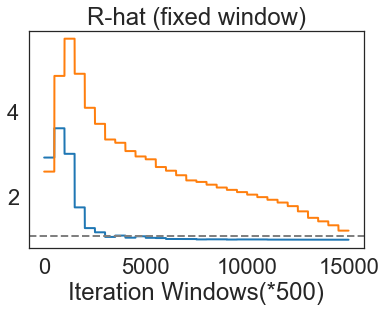

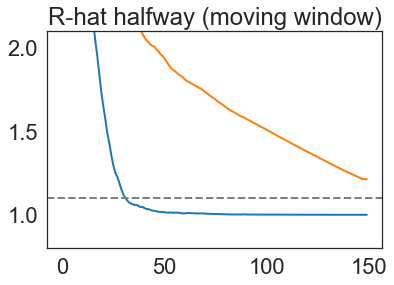

In [77]:
plt.plot(np.repeat(np.mean(R_hat_mean_window_fr_adam, axis=1), 500), label='mean')
plt.plot(np.repeat(np.mean(R_hat_sigma_window_fr_adam, axis=1), 500), label='sigma')
plt.ylim((0.8,5.9))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('R-hat (fixed window)')
plt.xlabel('Iteration Windows(*500)')

plt.figure()
plt.plot(np.mean(R_hat_mean_halfway_fr_adam, axis=1))
plt.plot(np.mean(R_hat_sigma_halfway_fr_adam, axis=1))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('R-hat halfway (moving window)')
plt.ylim((0.8,2.1))

#### Distance between true mean and approximate mean for ADAM and avaraged ADAM optimisers

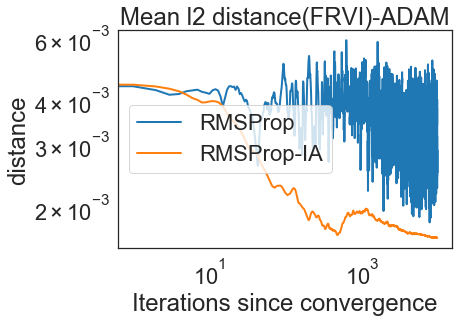

In [78]:
plt.loglog(np.mean(np.sqrt(np.square(mean_iters_fr_adam[op_log_fr_adam['start_avg_mean_iters']:] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_fr_mean_list_adam[0] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('distance')
plt.title('Mean l2 distance(FRVI)-ADAM')
plt.legend()

#### Distance between true covariance and approximate covariance for ADAM and avaraged ADAM optimisers

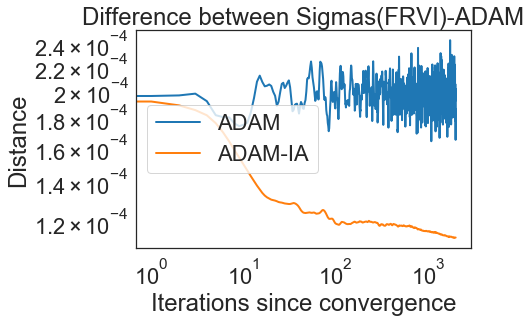

In [81]:
plt.loglog(np.mean(np.sqrt(np.square(cov_iters_fr_adam_flat[op_log_fr_adam['start_avg_sigma_iters']:] - true_cov.flatten())), axis=1), label='ADAM')
plt.loglog(np.mean(np.sqrt(np.square(cov_iters_fr_adam_ia_flat - true_cov.flatten())), axis=1), label='ADAM-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Difference between Sigmas(FRVI)-ADAM')
plt.legend()

#### Distance between true std dev. and approximate std dev. for ADAM and averaged ADAM optimisers

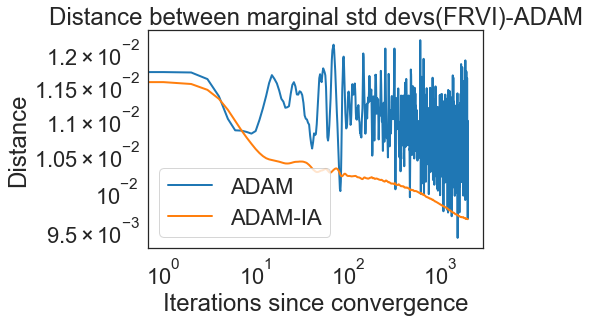

In [82]:
plt.loglog(np.mean(np.sqrt(np.square(cov_iters_fr_adam_std[op_log_fr_adam['start_avg_sigma_iters']:] - true_std)), axis=1), label='ADAM')
plt.loglog(np.mean(np.sqrt(np.square(cov_iters_fr_adam_ia_std - true_std)), axis=1), label='ADAM-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Distance between marginal std devs(FRVI)-ADAM')
plt.legend()

#### Distance between true z-scores. and approximate z-scores for ADAM and averaged ADAM optimisers

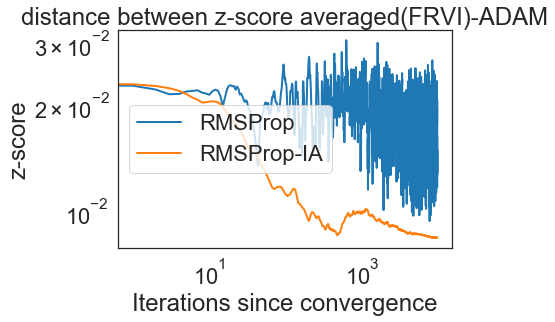

In [83]:
plt.loglog(np.mean(np.sqrt(np.square(mean_iters_fr_adam[op_log_fr_adam['start_avg_mean_iters']:] - true_mean)/true_std), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_fr_mean_list_adam[0] - true_mean)/true_std), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('distance between z-score averaged(FRVI)-ADAM')
plt.legend()

## Mean-field variational inference with CHIVI

We can repeat the same procedure, but this time using CHIVI and a Student t mean-field variational family. 